## XGBoost for Classification

I will now use XGBoost to solve my station availability status classification problem.

In [1]:
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
april_rides_downsampled = pd.read_csv('april_rides_downsampled.txt', delimiter=',')
april_rides_downsampled = april_rides_downsampled.drop('Unnamed: 0', axis=1)
april_rides_downsampled.head()

,status,tempF,neighborhood_Battery Park,neighborhood_Bedford Stuyvesant,neighborhood_Boerum Hill,neighborhood_Brooklyn Heights,neighborhood_Bushwick,neighborhood_Carnegie Hill,neighborhood_Carroll Gardens,neighborhood_Central Park,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,stat_size_Large,stat_size_Medium,stat_size_Small,ct_revised
0,High,62.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
1,High,62.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
2,High,69.8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,22
3,High,62.6,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,30
4,High,53.6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,30


## Modeling

In [3]:
april_rides_downsampled.status.value_counts()

Low         400000
Moderate    400000
High        400000
Name: status, dtype: int64

XGB needs to have the classes labeled as integer values.

In [4]:
april_rides_downsampled['status'] = [2 if i == 'High' else 1 if i == 'Moderate' else 0 for i in april_rides_downsampled.status]

In [5]:
y = april_rides_downsampled.status
X = april_rides_downsampled.drop('status', axis=1)

Similar to the forest models, I split the training data into 4 sets to make it easier for the models to digest the data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.5,
                                                              random_state=123)

X_train_1_1, X_train_1_2, y_train_1_1, y_train_1_2 = train_test_split(X_train_1, 
                                                                      y_train_1, 
                                                                      test_size=0.5,
                                                                      random_state=123)

X_train_2_1, X_train_2_2, y_train_2_1, y_train_2_2 = train_test_split(X_train_2, 
                                                                      y_train_2, 
                                                                      test_size=0.5,
                                                                      random_state=123)

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    
    # Check if normalize is set to True
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #This generates a 2D display
    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title(title) 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here I iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

Below I begin with a baseline model testing the full dataset.


Baseline Training Accuracy: 66.64%
Baseline Test Accuracy: 66.69%

Normalized confusion matrix
[[0.6762409  0.27089435 0.05286476]
 [0.20816922 0.52067857 0.27115222]
 [0.00580944 0.1897834  0.80440716]]


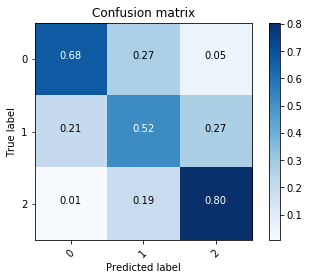

In [8]:
xgbclassifier = XGBClassifier(random_state=123)
xgbclassifier.fit(X_train, y_train)

#This is the accuracy score of the baseline training model
training_accuracy = xgbclassifier.score(X_train, y_train)

#This is the accuracy score of the baseline testing model
test_accuracy = xgbclassifier.score(X_test, y_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#plot a confusion matrix for the XGBoost model
y_hat_test = xgbclassifier.predict(X_test)
class_names = set(y)
cnf_mat_xgb = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cnf_mat_xgb, classes=class_names, normalize=True)

To tune the hyperparameters I have the options to train general, booster, and learning task parameters.

The general parameters define the overall functionality of the model - the type of model, silent (which determines if messages will be displayed), and nthread, which determines parallel processing. I elect not to tweak any of these from their default (tree-based, 0 - keep messages, and max # of threads).

For the booster parameters:
I initialize the model as a softmax classifier for multiclass problems and specify the number of classes to 3 - High, Moderate, and Low. 

I then begin by tweaking the learning rate. The learning rate selected by the model was 0.4, which is rather high. It suggests that additional estimators could likely be helpful in reducing the learning rate.

Max depth was then proposed. It is not surprising that the deeper tree is selected given what was seen in the RF model.

The subsample denotes the fraction of observations to be randomly sampled for each tree. Typically lower values will lead to underfitting.

In [9]:
pipe_xgb = Pipeline([('clf', XGBClassifier(objective='multi:softmax', 
                                           num_class=3, tree_method='hist', 
                                           random_state=123))])

xgb_grid = {'clf__learning_rate': [0.25, 0.4],
            'clf__max_depth': [25, 50, 70],
            'clf__subsample': [0.4, 0.5],
            'clf__n_estimators': [200, 300]}

gs_xgb = GridSearchCV(estimator=pipe_xgb, cv=2,
                      param_grid=xgb_grid, 
                      scoring='accuracy', 
                      verbose=1, refit=True, 
                      return_train_score=True)

print(gs_xgb)
gs_xgb.fit(X_train_1_1, y_train_1_1)
print('\nBest params:\n', gs_xgb.best_params_)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                                                      n_estimators=100,
                                                      n_jobs=1, nthread=None,
              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 432.4min finished



Best params:
 {'clf__learning_rate': 0.25, 'clf__max_depth': 25, 'clf__n_estimators': 200, 'clf__subsample': 0.5}


Here I build out the DMatrix of the 4 pairs of training X & y.

In [10]:
xgb_train_1 = xgb.DMatrix(X_train_1_1, label=y_train_1_1)
xgb_train_2 = xgb.DMatrix(X_train_1_2, label=y_train_1_2)
xgb_train_3 = xgb.DMatrix(X_train_2_1, label=y_train_2_1)
xgb_train_4 = xgb.DMatrix(X_train_2_2, label=y_train_2_2)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [11]:
#I set the parameters specified above.
params = {'objective': 'multi:softmax', 
          'num_class': 3, 
          'tree_method': 'hist', 
          'learning_rate': 0.25, 
          'max_depth': 25, 
          'n_estimators': 200, 
          'subsample': 0.5, 
          'random_state': 123}

In [12]:
#Here I train the first model and save it.
model_1 = xgb.train(params, xgb_train_1)
model_1.save_model('model_1.model')

In [13]:
#Here I train two versions of the model, one which is a new instance,
#and a second which references the first model. I then print the mse of the
#models' predictions of the test data to determine which had the best fit.
model_2_v1 = xgb.train(params, xgb_train_2)
model_2_v2 = xgb.train(params, xgb_train_2, xgb_model='model_1.model')
print(mse(model_1.predict(xgb_test), y_test))
print(mse(model_2_v1.predict(xgb_test), y_test))
print(mse(model_2_v2.predict(xgb_test), y_test))

0.2776625
0.2794375
0.24776666666666666


In [14]:
#Because the model which referenced the first had the best fit, I save that
#model and then run the process again and then a third time.
model_2_v2.save_model('model_2_v2.model')

# ================= train two versions of the model =====================#
model_3_v1 = xgb.train(params, xgb_train_3)
model_3_v2 = xgb.train(params, xgb_train_3, xgb_model='model_2_v2.model')
print(mse(model_3_v1.predict(xgb_test), y_test))
print(mse(model_3_v2.predict(xgb_test), y_test))

0.2781875
0.230675


In [15]:
model_3_v2.save_model('model_3_v2.model')

# ================= train two versions of the model =====================#
model_4_v1 = xgb.train(params, xgb_train_4)
model_4_v2 = xgb.train(params, xgb_train_4, xgb_model='model_3_v2.model')
print(mse(model_4_v1.predict(xgb_test), y_test))
print(mse(model_4_v2.predict(xgb_test), y_test))

0.27915416666666665
0.21863333333333335


In [16]:
#I will now run a full classifier on the data using the parameters specified 
#in the model
xgbclassifier = XGBClassifier(objective='multi:softmax', num_class=3, 
                              tree_method= 'hist', learning_rate=0.25, max_depth=25, 
                              n_estimators= 200, subsample= 0.5, random_state=123)
xgbclassifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.25, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.5, tree_method='hist')


Baseline Training Accuracy: 90.16%
Baseline Test Accuracy: 86.66%

Normalized confusion matrix
[[0.88348227 0.10320142 0.01331631]
 [0.12149125 0.79139453 0.08711422]
 [0.00872668 0.06615751 0.92511581]]


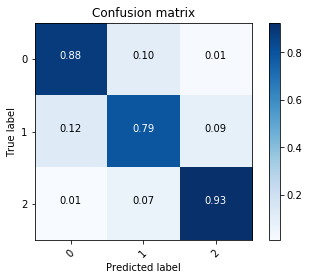

In [17]:
#This is the accuracy score of the baseline training model
training_accuracy = xgbclassifier.score(X_train, y_train)

#This is the accuracy score of the baseline testing model
test_accuracy = xgbclassifier.score(X_test, y_test)

print("")
print('Baseline Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Baseline Test Accuracy: {:.4}%'.format(test_accuracy * 100))
print("")

#plot a confusion matrix for the XGBoost model
y_hat_test = xgbclassifier.predict(X_test)
class_names = set(y)
cnf_mat_xgb = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cnf_mat_xgb, classes=class_names, normalize=True)

In [32]:
import joblib
from joblib import dump

xgb_mod_1 = xgbclassifier

dump(xgb_mod_1, '/Users/zazue/PycharmProjects/TrialforCapstone/venv2/xgb_mod_1.joblib')

['/Users/zazue/PycharmProjects/TrialforCapstone/venv2/xgb_mod_1.joblib']

### Takeaways

Overall performance is slightly better than the RF model, but we see worse performance in the Low (0) class, which is what I deemed to be more important for the consumer.

Significant performance increase after tweaking the parameters.